# 1EG 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('data/1EG.csv')

In [4]:
df.head()

,POVRSINA,BR_OSOBA,MJESEC_sin,MJESEC_cos,MJESEC,GODINA,S_SNAGA,ENESGR
0,NaN,NaN,-0.866025,0.5,10,2010,0.019850,3.494
1,NaN,NaN,-0.866025,0.5,10,2010,0.009742,1.153
2,NaN,NaN,-0.866025,0.5,10,2010,0.044751,5.955
3,NaN,NaN,-0.866025,0.5,10,2010,0.007539,1.829
4,NaN,NaN,-0.866025,0.5,10,2010,0.053865,4.536


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661191 entries, 0 to 661190
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   POVRSINA    268818 non-null  float64
 1   BR_OSOBA    25190 non-null   float64
 2   MJESEC_sin  661191 non-null  float64
 3   MJESEC_cos  661191 non-null  float64
 4   MJESEC      661191 non-null  int64  
 5   GODINA      661191 non-null  int64  
 6   S_SNAGA     661069 non-null  float64
 7   ENESGR      521802 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 40.4 MB


## Grafovi

### Provjera korelacija

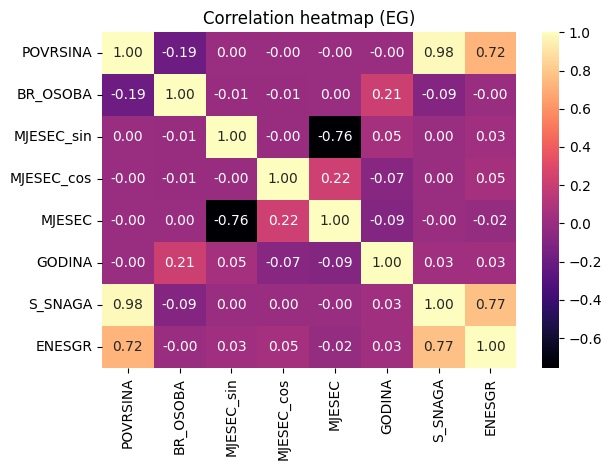

In [6]:
corr = df.corr()

ax = sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f")
ax.set_title("Correlation heatmap (EG)")

plt.tight_layout()
plt.show()

Vidimo da zapravo korelacija izmedu mjeseca i potrosnje nije toliko bitna, ali je snaga na jedinici preko koje se direktno i racuna potrosnja. Takoder vidimo da broj osoba nema utjecaja, ali povrsina je jako korelirana i to cemo koristiti u nastavku.

## Trendovi podataka

In [7]:
def diagnose_features(data, features, target):
    num_features = len(features)
    rows = (num_features + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        # Crtamo podatke i trend
        sns.regplot(
            data=data, 
            x=col, 
            y=target, 
            ax=axes[i],
            scatter_kws={'alpha': 0.2, 's': 10}, 
            line_kws={'color': 'red'},
            lowess=True # Lowess crta liniju koja prati lokalni trend (otkriva zakrivljenost)
        )
        axes[i].set_title(f'{target} vs {col}')
        axes[i].grid(True, linestyle='--', alpha=0.6)

    # Brišemo prazne grafove ako ih ima
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

/Users/dzanijaivan/Developer/AnomalyDetection/.venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


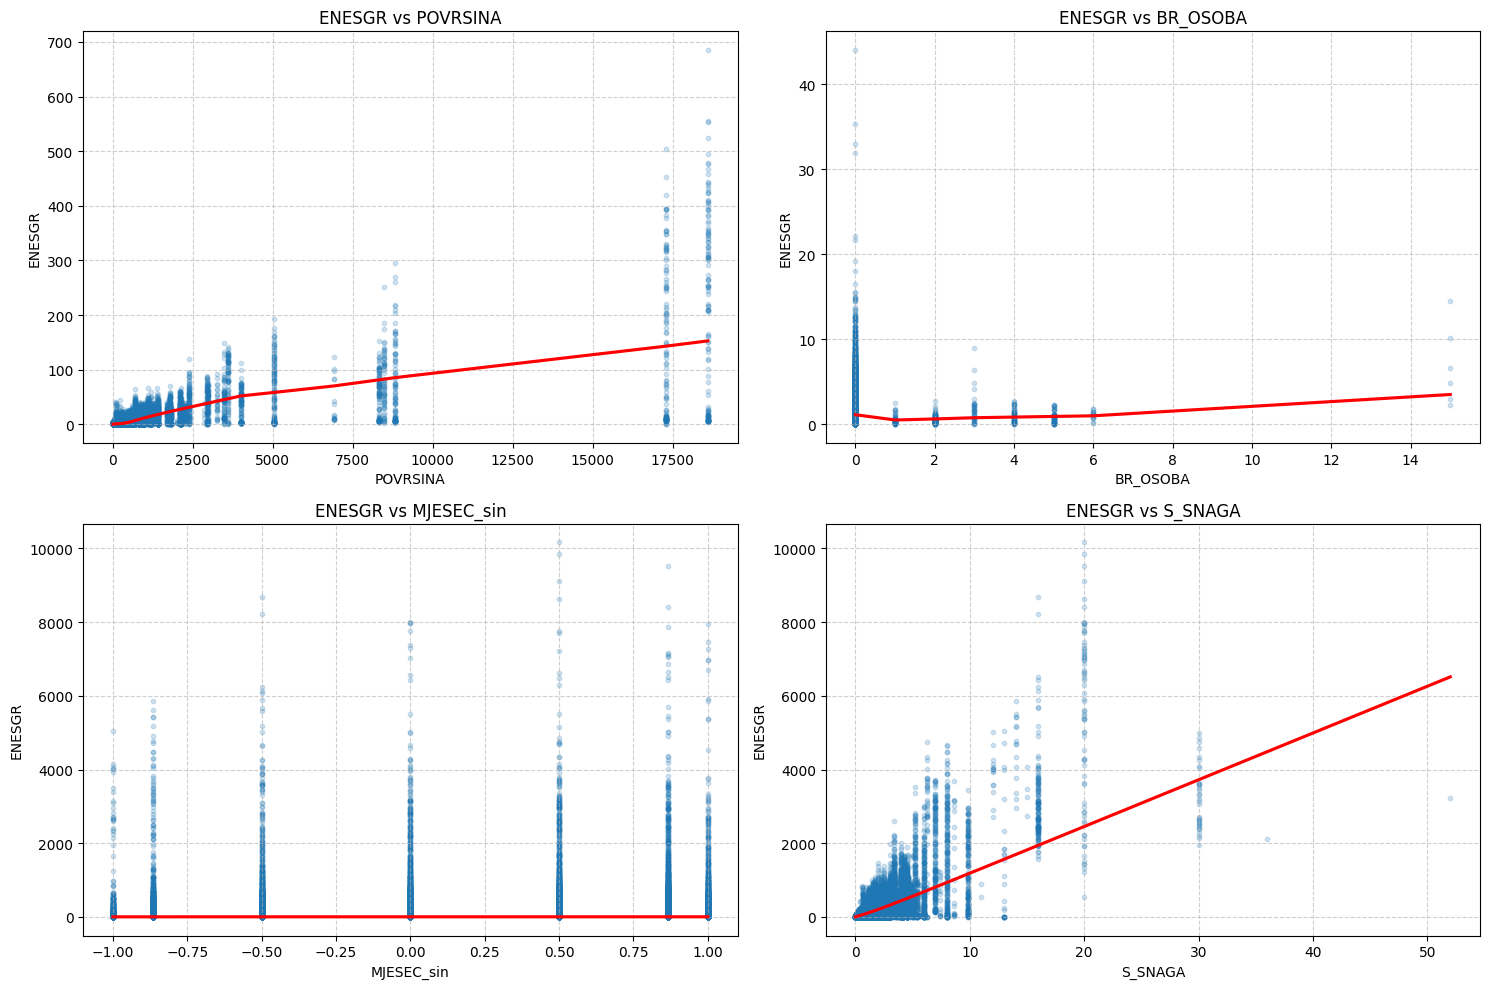

In [8]:
diagnose_features(df, ['POVRSINA', 'BR_OSOBA', 'MJESEC_sin', 'S_SNAGA'], 'ENESGR')

Ovime smo se uvjerili da broj osoba ima zanemariv ucinak na ukupnu potrosnju energije neke jedinice.

## Grupiranje 

### K-sredina

In [9]:
from sklearn.metrics import silhouette_score

# Metoda za trazenje optimaknog k nad podatcima i znacajkama
def find_optimal_k(data, features, title):
    # Filtriranje i priprema podataka
    X_sub = data[features].dropna()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_sub)
    
    inertia = []
    silhouette_avg = []
    K_range = range(2, 9)

    print(f"\n--- Analiza za: {title} ---")
    print(f"{'k':<5} | {'Inertia':<15} | {'Silhouette Score':<15}")
    print("-" * 40)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        
        # Pohrana inertije
        current_inertia = kmeans.inertia_
        inertia.append(current_inertia)
        
        # Silhouette score na CIJELOM skupu podataka
        current_silhouette = silhouette_score(X_scaled, labels)
        silhouette_avg.append(current_silhouette)
        
        print(f"{k:<5} | {current_inertia:<15.2f} | {current_silhouette:<15.4f}")

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Broj klastera (k)')
    ax1.set_ylabel('Inertia (Lakat)', color='blue')
    ax1.plot(K_range, inertia, 'bo-', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--', alpha=0.3)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Score', color='red')
    ax2.plot(K_range, silhouette_avg, 'ro-', linewidth=2)
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'Određivanje optimalnog k za: {title}')
    plt.tight_layout()
    plt.show()

In [ ]:
# Procjena optimalnog broja grupa
_features = ['POVRSINA']
find_optimal_k(df, _features, "Grijanje (1EG)")


--- Analiza za: Grijanje (1EG) ---
k     | Inertia         | Silhouette Score
----------------------------------------
